In [2]:
import numpy as np

import random
import math
from matplotlib import pyplot as plt

# Monte Carlo Simulation Cathodoluminescence 
Following Meuret, Kociak, et. al., PRL & supplemental material. 


We outline the experimental and some material parameters taken from the literature which are allow our caculations to be realistic with respect to materials properties. 

#### Energy-scales
The electrons are accelerated with $60 keV$ potential. At this energy scale the electrons move at a veloctity $v = .44 * c$ 

1. Plasmon modes should be $\mathcal{O}(10 eV)$ excitations. This correlates well with the big EELS peak around 40 eV in Kociak's supplemental material. 
2. Electron-hole exicton pairs are of $E_{eh} = 5 eV$ as per the band-gap in diamond
3. NV$^0$ centers with $2.156 eV$ (575nm) energy gap between a doublet $^2E$ states and $^2A$ states. The NV gap isembedded within the semiconductor band-gap. 
4. There exist phonon bands with much lower energies than all the modes listed above. Photons exhibiting maximal bunching lie between 610-665 nm and this corresponds to a loss of $\sim .25eV$



In [5]:
ev_c2 = 1.783e-36   # eV/c^2 in units of kg
me_kg   = 9.1e-31   # mass of e- [kg]
me = me_kg/ev_c2    # mass of e- [eV/c^2]
c = 3e8             # speed of light [m/s]

v = np.sqrt(1-(510/(60+510))**2) # speed of e- w.r.t c i.e., gamma factor
print('(non)relativistic electron velocity(/c) is ' +str(v) + ' (' + str(np.sqrt(2*60/510)) + ')')      # v vs. non-relativistic calculation for velocity

h = 4.135e-15       # plank's constant [eV]  (not h-bar, just h)
l_NV = 575          # nv wavelength [nm]
f_NV = c*1e9/l_NV   # frequency (conversion nm <--> m)
E_NV = h * f_NV     # energy [eV]
E_660 = h * (c*1e9/660)
E_610 = h * (c*1e9/610)
DE = E_NV - E_660   # energy lost to plasmon [eV]
print('energy lost to plasmon around ' + str(DE) + ' eV')


q = 1.602e-19       # electron charge [C]
I0 = q/1e-9 * 1e9   # current for 1 e- per ns [nA]
print('current for 1e- per 1 nanosecond is ' + str(I0) + ' nA')

(non)relativistic electron velocity(/c) is 0.446593756539 (0.485071250073)
energy lost to plasmon around 0.27784584980237126 eV
current for 1e- per 1 nanosecond is 0.1602 nA


#### Timescales

The e-beam current depends on the extraction voltage which removes electrons.In the Kociak paper the currents range between $1pA$-$100pA$ while the ORNL experiment uses currents betwee $100 pA$ to $10 nA$. 

0. Bunching bandwidth of $\sim 100ns$ for 610 nm and 665 nm filtered data.
1. NV decay timescales seems to be on the order of $\mathcal{O}(10ns)$. 

In [236]:
dt = 1                                  # time step in units of 10 [ps]
tm = 1e2 * dt                           # mean arrival time for em -- related to the current 
t_f = 1e4 * dt                          # simulation end time
t_em = np.linspace(0,t_f,int(t_f/dt))   # discretize time domain


# radiation statistical properties
tau_NV = 1e3 * dt                       # timescale for NV relaxation
p_rad = 1 - np.exp(-dt/tau_NV)          # emission probability at each timestep

# electron statistical properties
l_em = dt/tm                            # lambda parameter for poisson distribution of e- arrivals
p_em = l_em * np.exp(-l_em)             # probabilty of e- arrival & interaction within dt

# plasmon statistical properties
l_pl = 5                               # poissonian lambda for plasmon generation 
                                        # ==thickness/mean free path == avg plsmon number
n_pl_max = 150                          # max plasmons number cutoff
p_pl_pdf = [l_pl**n * np.exp(-l_pl)     # poisson pdf for plasmon generation
            / math.factorial(n) for n in range(n_pl_max)] 


# plasmon poissoinian cumulative distribution function
p_pl_cdf = [0] * n_pl_max             
for i in range(n_pl_max):   
    if i == 0:
            p_pl_cdf[0] = p_pl_pdf[0]
    else:
            p_pl_cdf[i] = p_pl_cdf[i-1] + p_pl_pdf[i]
            
def pick_npl(r, dist = p_pl_cdf):
    """
    draw plasmon number from 
    PARAMETERS
    ----------
    r: random number in [0,1]
    dist: cumulative distribution function sampled (p_pl_cdf by default)

    RETURNS
    -------
    # of plasmons excited
    """
    for p in dist:
        if r > p:
            pass
        else:
            return dist.index(p)
        
# e-h exciton statistics
n_eh = 3                                 # number of e-h pairs excited per plasmon

# NV excitation statistics
# p_INT = 1 - np.exp(-1/2)               # probability to excite NV
p_INT = .1


    
NVs = [0] * len(t_em)                    # pre-allocate list for NVs excited at each timestep

em_arrivals = [0] * len(t_em)            # track arrival/excitations times for all modes
pl_arrivals = [0] * len(t_em)
nv_arrivals = [0] * len(t_em)

for i, t in enumerate(t_em):             # loop through discretized time domain    
    for l in range(i):                   # stocastically relax NVs excited at earlier times t_l < t_i
        if NVs[l] != 0:                  # exclude times w/ no excited NVs
            for m, n in enumerate(NVs[l]):
#                 print('Looking backwards to NVs excited at time ' + str(l))
                if random.random() < p_rad and n[1] == 0:
#                     print('Radiative event triggered at time ' + str(t_em[l]))
#                     print('index and excitation times ')
#                     print(m, n)
                    NVs[l][m][1] = t     # assign emission time 
    
    
    if  random.random() < p_em:                   # successful electron nano-crystal interaction 
        npl = pick_npl(random.random())           # number of plasmon modes populated according to p_pl_cdf
        
        NVs[i] = [[t,0] for j in range(npl)       # mark time of arrival 
                  for k in range(n_eh)            
                  if random.random() < p_INT]

        # track all exictations at each time-step
        em_arrivals[i] = 1                        # electrons
        pl_arrivals[i] = npl                      # plasmons

        if len(NVs[i]) == 0:
            NVs[i] = 0
            nv_arrivals[i] = 0
        else:
            nv_arrivals[i] = len(NVs[i])              # NVs
        
        
# plt.plot(p_pl_pdf)
# plt.plot(p_pl_cdf)
# plt.show()
sum(em_arrivals) ,sum(em_arrivals)/len(t_em), p_em

(94, 0.0094, 0.0099004983374916811)

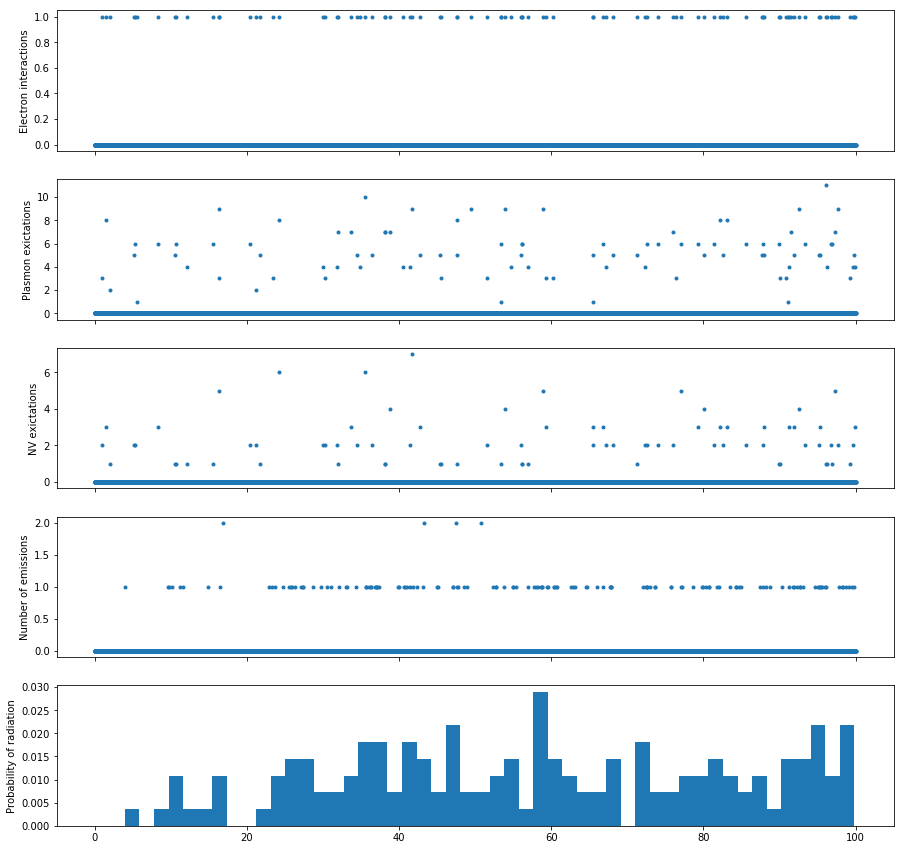

total time is 10000

94 electrons were excited 

500 plasmons were excited 

181 NV centers were excited 

144 radiation events were detected


In [237]:
exicted_NVs = [n for n in NVs if n != [] and n != 0]
rad_times = [t[1] for times in exicted_NVs for t in times if t[1] != 0]
rad_times.sort()
rad_times_ns = [r * 0.01 for r in rad_times]           # rescaling of radiation times to [ns] units


tofe = [rad_times.count(t) for t in t_em]              # emissions per time

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(15,15))

ax[0].plot(t_em * 0.01, em_arrivals,'.',)
ax[1].plot(t_em * 0.01, pl_arrivals,'.')
ax[2].plot(t_em * 0.01, nv_arrivals, '.')
ax[3].plot(t_em * 0.01, tofe, '.')
ax[4].hist(rad_times_ns, normed=True, bins=50)


ax[0].set_ylabel('Electron interactions')
ax[1].set_ylabel('Plasmon exictations')
ax[2].set_ylabel('NV exictations')
ax[3].set_ylabel('Number of emissions')
ax[4].set_ylabel('Probability of radiation')
plt.show()

# print total: # timesteps, e- arrivals, plasmon excitations, nv_excitations
print("total time is " + str(len(t_em)) + "\n")
print(str(sum(em_arrivals)) + " electrons were excited \n")
print(str(sum(pl_arrivals)) + " plasmons were excited \n")
print(str(sum(nv_arrivals)) + " NV centers were excited \n")
print(str(sum(tofe)) + ' radiation events were detected')

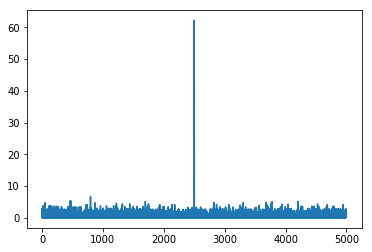

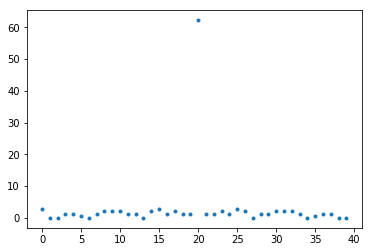

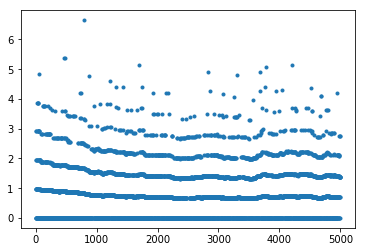

In [238]:
tau_max = int(len(tofe)/4)
data0 = tofe[tau_max:3 * tau_max]
mu_2 = np.mean(data0)**2
def data(delay):
    """
    Time series day with integer delay
    """
    return tofe[0 + delay: 2 * tau_max + delay]

corr_data = [0] * 2 * tau_max
for i in range(2 * tau_max):
    di = data(i)
    corr_data[i] = sum(data0[j] * di[j] for j in range(2 * tau_max))/(2 * tau_max * np.mean(data0) * np.mean(di))

plt.plot(corr_data)
plt.show()


plt.plot(corr_data[tau_max-20:tau_max+20], '.') #zoom into zero delay signal window
plt.show()

corr_data.pop(tau_max)
plt.plot(corr_data, '.')
plt.show()


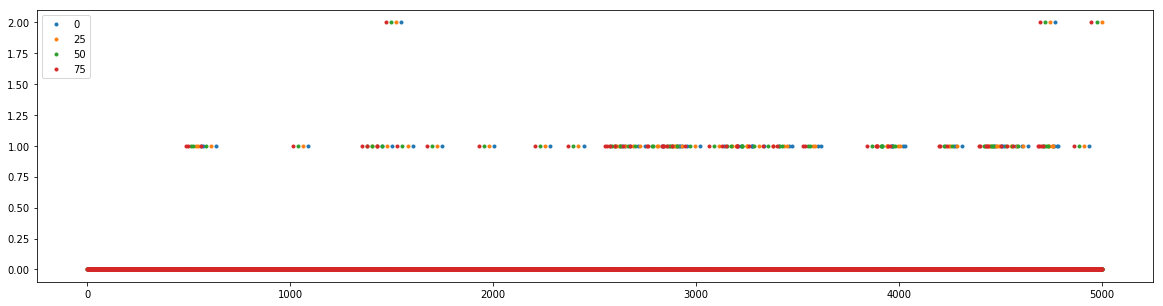

In [229]:
len(t_em[0:2 * tau_max]), len(data(0))


plt.figure(figsize=(20,5))
for i in [0,25,50,75]:
    plt.plot(t_em[0:2 * tau_max + 0], data(i),'.', label = str(i))

plt.legend()
plt.show()

In [244]:
rad_times_ns

[3.9503950395039498,
 9.63096309630963,
 9.7409740974097403,
 10.18101810181018,
 11.141114111411142,
 11.651165116511649,
 14.85148514851485,
 16.421642164216422,
 16.801680168016802,
 16.801680168016802,
 22.842284228422841,
 23.262326232623259,
 23.682368236823681,
 24.772477247724769,
 25.502550255025501,
 25.752575257525752,
 25.952595259525953,
 26.282628262826279,
 27.13271327132713,
 27.332733273327332,
 27.352735273527351,
 28.64286428642864,
 29.692969296929693,
 30.493049304930491,
 31.11311131113111,
 32.133213321332136,
 33.013301330133011,
 33.113311331133112,
 34.313431343134312,
 35.633563356335628,
 35.713571357135713,
 36.103610361036097,
 36.323632363236321,
 36.333633363336332,
 36.883688368836879,
 36.923692369236917,
 37.03370337033703,
 37.08370837083708,
 37.383738373837382,
 39.91399139913991,
 39.993999399939987,
 40.63406340634063,
 40.744074407440742,
 41.084108410841083,
 41.454145414541458,
 41.814181418141807,
 42.344234423442337,
 43.074307430743076,
 43

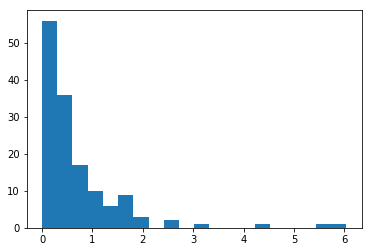

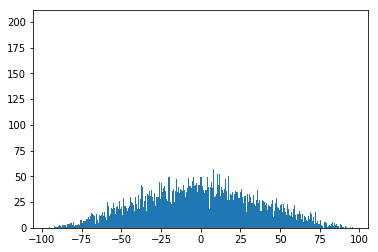

In [249]:
# Delay function in the sytle of kociak. 
# How is this really related to the autocorrelation function
# 256 ps bin-sizes


delaytimes = [rad_times_ns[i+1] - rad_times_ns[i] for i in range(len(rad_times_ns)-1)]

plt.hist(delaytimes, bins=20)
plt.show()

We now estimate the g2 correlation function by playing a little trick with the way that the time series emission data is interpreted. Namely, we go through the radiation events selecting a single reference event, let us say it is the $i$th event.
We imagine that this photon was detected by the first detector (click!) at time $t_i$. 
We now count the 'binned coincidences' by tagging other radiative emissions within a time window ($2 \tau_{MAX}$) centered about $t_i$, that is, $\tau^{(i)}_g = \left[ t_0 - \tau_{MAX} , \tau_0 +  \tau_{MAX} \right]$.




In [253]:
TTM = 1e3     # 2 * \tau_MAX

for ti in radtimes:
    if ti > TTM & ti < max(t_em)- TTM: # make sure TTM time gap exists to left and right of t_i
        


9000.0

In [251]:
rad_times

[395.03950395039499,
 963.09630963096299,
 974.09740974097406,
 1018.101810181018,
 1114.1114111411141,
 1165.116511651165,
 1485.1485148514851,
 1642.1642164216421,
 1680.1680168016801,
 1680.1680168016801,
 2284.2284228422841,
 2326.2326232623259,
 2368.2368236823681,
 2477.2477247724769,
 2550.2550255025499,
 2575.257525752575,
 2595.2595259525951,
 2628.2628262826279,
 2713.2713271327129,
 2733.2733273327331,
 2735.2735273527351,
 2864.2864286428639,
 2969.2969296929691,
 3049.3049304930491,
 3111.3111311131111,
 3213.3213321332132,
 3301.3301330133008,
 3311.3311331133109,
 3431.3431343134312,
 3563.356335633563,
 3571.3571357135711,
 3610.3610361036099,
 3632.363236323632,
 3633.363336333633,
 3688.3688368836879,
 3692.3692369236919,
 3703.370337033703,
 3708.370837083708,
 3738.3738373837382,
 3991.3991399139909,
 3999.3999399939989,
 4063.4063406340629,
 4074.4074407440739,
 4108.4108410841081,
 4145.4145414541454,
 4181.4181418141807,
 4234.423442344234,
 4307.4307430743074,
 

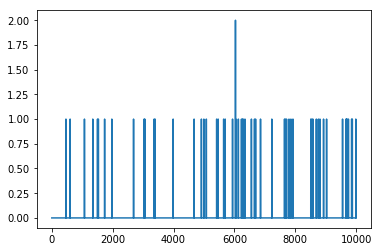

the number of timesteps during which an emission did NOT take place is 9942


In [144]:
plt.plot(tofe)
plt.show()

not_emissions = 0
for i,t in enumerate(tofe):
    if t == 0:
        not_emissions +=1
print('the number of timesteps during which an emission did NOT take place is ' + str(not_emissions))

Find proper radiation probability given a mean lifetime/halflife for the NV relaxation events

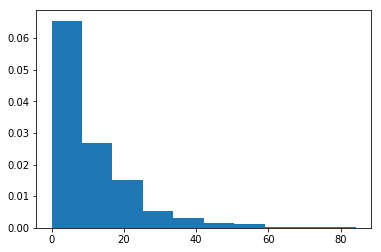

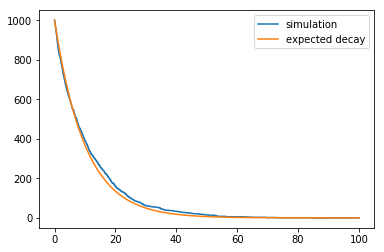

In [131]:
em_times = [0] * 1000
counter = [0] * len(t_em)
counter[0] = len(em_times)

for i,t in enumerate(t_em):
    
    if i > 0:
        counter[i] = counter[i-1]
    
    emissionss = 0
    for j in range(len(em_times)):
        if em_times[j]==0 and random.random() < p_rad:
            em_times[j] = t * 0.01
            emissionss += 1
     
    counter[i] = counter[i] - emissionss

nzn_times = [e for e in em_times if e != 0.0]
plt.hist(nzn_times, normed=True, bins=10)
plt.show()

decay_t = [len(em_times) * (np.exp(-t/tau_NV)) for t in t_em]
plt.plot(t_em * 0.01, counter, label = 'simulation')
plt.plot(t_em * 0.01, decay_t, label = 'expected decay')
plt.legend()
plt.show()
